# To do list

- Aplicar distintos tipos de filtro a downsampling (función $\texttt{lowpass}$\_$\texttt{filter}$)
- Aplicar algoritmo de denoising (función $\texttt{denoising}$\_$\texttt{signal}$)
- Aplicar algoritmo de corte de frecuencias en eliminación de murmur (función $\texttt{murmur}$\_$\texttt{elimination}$)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy import signal
from IPython.display import Audio
import wavio
import pywt

In [3]:
def recognize_peaks_by_derivates(x, signal_in, peak_type='min', tol_dx=0.01,
    tol_d2x=1e-2, lookup=1500, plot=False):
    # Se definen las derivadas 
    dx = np.gradient(signal_in, x)
    d2x = np.gradient(dx, x)
    
    # Buscando los puntos donde la derivada se vuelve cero
    der_vect_0 = [i for i in range(len(dx)) if abs(dx[i]) <= tol_dx]
    
    # Y definiendo si estos puntos corresponden a mínimos o máximos se realiza
    if peak_type == 'min':
        sel_indexes = [i for i in der_vect_0 if d2x[i] >= tol_d2x]
    elif peak_type == 'max':
        sel_indexes = [i for i in der_vect_0 if d2x[i] <= - tol_d2x]
    elif peak_type == 'all':
        sel_indexes = der_vect_0
    else:
        raise ValueError('La opcion de eleccion de peak utilizada no es valida.')
    
    # Seleccionando un punto característico de la región (ya que
    # muchos de los "puntos" aparecen agrupados en más puntos). En primer lugar,
    # se obtiene un vector de diferencias para conocer los puntos en los que se
    # pasa de un cluster a otro
    dif_indexes = [i + 1 for i in range(len(sel_indexes) - 1)
                   if sel_indexes[i + 1] - sel_indexes[i] > 1] + \
                  [len(sel_indexes) + 1]

    # Separando los clusters de puntos y encontrando el índice representativo de
    # cada uno
    begin = 0
    out_indexes = []
    for i in dif_indexes:
        # Definición del punto posible. Se hace round en caso de que sea un
        # decimal, e int para pasarlo si o si a un elemento tipo "int" para
        # indexar 
        possible_point = int(round(np.mean(sel_indexes[begin:i])))
        
        # Finalmente, se debe reconocer si este punto es realmente un mínimo o
        # un  máximo y no un punto de inflexión. Para ello se revisará en un
        # rango de 'lookup' alrededor de este punto. Definiendo los puntos a
        # revisar 
        look_before = signal_in[possible_point - lookup] \
            if possible_point - lookup >= 0 else signal_in[0]
        look_after  = signal_in[possible_point + lookup] \
            if possible_point + lookup <= len(signal_in) else signal_in[len(signal_in)-1]

        # Luego, realizando la comparación
        if peak_type == 'min':
            # Corroborando que alrededor de este punto se forma un "valle"
            if (look_after > signal_in[possible_point] and 
                look_before > signal_in[possible_point]):
                out_indexes.append(possible_point)

        elif peak_type == 'max':
            # Corroborando que alrededor de este punto se forma una "cueva"
            if (look_after < signal_in[possible_point] and 
                look_before < signal_in[possible_point]):
                out_indexes.append(possible_point)
        
        elif peak_type == 'all':
            # Corroborando alguno de los 2 casos anteriores
            if (look_after > signal_in[possible_point] and 
                look_before > signal_in[possible_point]) or \
               (look_after < signal_in[possible_point] and 
                look_before < signal_in[possible_point]):
                out_indexes.append(possible_point)

        # Redefiniendo el comienzo del análisis
        begin = i
    
    # Graficando para corroborar visualmente
    if plot:
        plt.subplot(3,1,1)
        plt.plot(signal_in)
        plt.plot(out_indexes, [signal_in[i] for i in out_indexes], 'rx')

        plt.subplot(3,1,2)
        plt.plot(dx)

        plt.subplot(3,1,3)
        plt.plot(d2x)

        plt.show()

    return out_indexes

In [32]:
def decimation_signal(signal_in, step):
    return signal_in[::step]

def stretching_signal(signal_in, N_stretch):
    return np.array([signal_in[i//N_stretch] if i%N_s == 0 else 0
                     for i in range(len(signal) * N_stretch)])

def moving_average(signal_in, Lf):
    # Definición de N
    N = len(signal_in)
    # Creación del vector del resultado
    result = np.zeros(N)
    
    # Se hace el promedio para cada segmento
    for n in range(N):
        if 0 <= n <= Lf - 1:
            result[n] = np.divide(sum(signal_in[:n+Lf+1]), Lf + n + 1)
        elif Lf <= n <= N - Lf - 1:
            result[n] = np.divide(sum(signal_in[n-Lf:n+Lf+1]), 2*Lf + 1)
        elif N - Lf <= n <= N - 1:
            result[n] = np.divide(sum(signal_in[n-Lf:N]), Lf + N - 1)
            
    return result

def find_valley_point(signal_in):
    # En primer lugar, encontrar el primer punto máximo de la señal (peak)
    primary_peak = np.argmax(signal_in)
    # print(primary_peak)
    

def thresholding_for_denoising(signal_in, delta=None, threshold_criteria='soft',
                               threshold_type='mad', min_percentage=None):
    '''Definición de los tipos de thresholding aplicados a una función transformada
    al dominio wavelet.
    Referencias: 
    - http://www.numerical-tours.com/matlab/denoisingwav_1_wavelet_1d/
    - https://dsp.stackexchange.com/questions/15464/wavelet-thresholding
    '''
    # Definición del umbral de corte
    if delta is None:
        if threshold_type == 'mad':
            # Se calcula la mediana
            med = np.median(signal_in)
            # Y se obtiene el sigma usando la median absolute deviation (MAD)
            sigma = np.median(abs(signal_in - med)) / 0.6745
            # Luego delta está dado por
            delta = np.sqrt(sigma) * np.sqrt(2 * np.log(len(signal_in)))
    
        elif threshold_type == 'percentage':
            delta = min_percentage * max(abs(signal_in))
    
    # Opciones de corte para el umbral
    if threshold_criteria == 'hard':
        return np.array([i if abs(i) > delta else 0 for i in signal_in])
    
    elif threshold_criteria == 'soft':
        # Definición de la operación soft
        soft_operator = lambda x: max(0, 1 - delta/abs(x + 1e-15)) * x
        return np.array([soft_operator(i) for i in signal_in])    
    

def zeropadding_to_pot2(signal_in):
    '''Se busca saber entre qué potencias de 2 se encuentra se encuentra el largo del arreglo,
    el cual está dado por aplicar el logaritmo base 2 al largo de la señal. Con esto, se 
    obtiene la cantidad de 'potencias de 2' que hay que aplicar al largo para obtenerlo.
    Se toma este número, y se obtiene la parte entera de él.
    
    Esta función busca rellenar con ceros hasta que el largo de la señal sea una potencia de 2.
    
    Parámetros
    - signal_in: Señal a rellenar con ceros'''
    # Pasar la señal a arreglo de numpy
    signal_in = np.array(signal_in)
    
    # Potencia de 2 por lo bajo del largo de la señal
    n2_pot = int(np.log2(len(signal_in)))
    
    # Luego, la cantidad de ceros que hay que agregar a la señal para 
    # que sea tenga como largo una potencia de 2 corresponde a 
    # 2 ** (n2_pot+1) - largo_de_señal
    n = n2_pot + 1
    
    return np.append(signal_in, [0] * (2**n - len(signal_in)))



def find_potential_onset_offset(signal_in, det_type):
    '''Función que permite encontrar los potenciales onsets basado en la
    revisión de puntos adyacentes. Se revisa si es que el punto actual es 
    cero y el punto siguiente es distinto de cero. Si se cumple, es porque
    se está en presencia de un "onset".
    
    Parámetros
    - signal_in: Señal de entrada
    - det_type: Opción para el tipo de salida
        - [onset]: Retorna los onset (inicio de sonidos cardíacos)
        - [offset]: Retorna los offset (fin de sonidos cardíacos)
    '''
    
    if det_type == 'onset':
        return [i for i in range(len(signal_in)-1) 
                if signal_in[i] == 0 and signal_in[i+1] != 0]
    elif det_type == 'offset':
        return [i for i in range(1, len(signal_in)) 
                if signal_in[i-1] != 0 and signal_in[i] == 0]
    else:
        raise('Opción seleccionada no es válida. Ingrese un tipo de salida '
              'disponible en las opciones.')
        

In [5]:
def wavelet_decomposition(signal_in, wavelet='db4', mode='periodization'):
    '''Esta función permite descomponer una señal de entrada en todos los
    posibles niveles de wavelet producto de la aplicación de la "Discrete
    Wavelet Transform" (DWT). 
    '''
    # Definición de la señal a descomponer
    to_decompose = signal_in
    
    # Definición del vector wavelet de salida
    wavelet_out = np.array([])
    
    while len(to_decompose) > 1:
        # Descomposición de wavelet
        (to_decompose, cD) = pywt.dwt(to_decompose, wavelet=wavelet, 
                                      mode=mode)
        
        # Agregando el detalle al final del vector de salida
        wavelet_out = np.append(cD, wavelet_out)
        
    return np.append(to_decompose, wavelet_out)


def wavelet_recomposition(signal_in, wavelet='db4', mode='periodization'):
    '''Esta función permite recomponer una señal de entrada en todos los
    posibles niveles de wavelet producto de la aplicación de la "Discrete
    Wavelet Transform" (DWT).
    '''
    # Definición del vector de datos de salida
    data_out = np.array([]) 
    
    # Definición de los niveles de reconstrucción
    N = int(np.log2(len(signal_in)))
    
    # Definición de la señal a recomponer
    cA = np.array([signal_in[0]])
    
    for i in range(N):
        to_look = 2 ** (i+1)
        
        # Definición del cD y cA de turno
        cD = signal_in[to_look//2:to_look]
        cA = pywt.idwt(cA, cD, wavelet=wavelet, 
                       mode=mode)
        
    return cA

In [6]:
def erosion_dilation_operation(signal_in, Q, op_type='erosion',
                               g_type='zeros',g_def=None):
    '''Definición de la operación de erosión/dilatación basada en 
    transformaciones morfológicas. 
    
    Disponible en: 
    - https://en.wikipedia.org/wiki/Erosion_(morphology)
    - https://en.wikipedia.org/wiki/Dilation_(morphology)
    
    Ref. anexa: https://opencv-python-tutroals.readthedocs.io/en/latest/
    py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
    
    Parámetros
    - signal_in: Señal a erosionar/dilatar
    - Q: Tamaño del kernel g(n) (si es par, se le suma 1)
    - g_type: Tipo de kernel a usar.
        - [zeros]: Vector cero de largo Q (o Q+1)
        - [user_defined]: Vector de largo Q (o Q+1) a definir por el usuario
        
    ** Nota **: Se usa Q+1 para que el queden ventanas de largo impar con un
    único punto central.
    '''
    # Propiedad de Q (si es par, se le suma 1)
    if Q % 2 == 0:
        Q += 1
        
    # Definición del radio de la ventana (window ratio)
    ratio = Q // 2
    
    # Definición de N
    N = len(signal_in)
    
    # Definición del kernel g(n)
    if g_type == 'user_defined':
        g_n = g_def[:Q+1]
    elif g_type == 'zeros':
        g_n = np.zeros(Q+1)
        
    # Definición de la función a aplicar
    if op_type == 'erosion':
        func = lambda x: min(x)
    elif op_type == 'dilation':
        func = lambda x: max(x)
    
    # Creación del vector de erosión
    signal_out = np.zeros(N)

    # Se hace aplica erosión dependiendo del segmento. Esto se hace ya que las
    # ventanas que están en los bordes de la señal no alcanzan necesariamente a
    # juntar los Q puntos. Por ende, es necesario ajustar los tamaños de las
    # ventanas en los bordes
    for n in range(N):
        if 0 <= n <= Q//2 - 1:
            signal_out[n] = func(signal_in[:n+ratio+1])
        elif Q//2 <= n <= N - Q//2 - 1:
            signal_out[n] = func(signal_in[n-ratio:n+ratio+1])
        elif N - Q//2 <= n <= N - 1:
            signal_out[n] = func(signal_in[n-ratio:])
    
    # Se entrega finalmente el vector erosionado
    return signal_out


def closing_operation(signal_in, Q=30, g_type='zeros',g_def=None,
                      normalized=True):
    '''Operación morfológica que permite obtener la envolvente de la señal.
    Corresponde a dilatar y luego erosionar la señal.
    Referencias: 
    - Qingshu Liu, et.al. An automatic segmentation method for heart sounds.
      2018. Biomedical Engineering.
    - https://homepages.inf.ed.ac.uk/rbf/HIPR2/close.htm'''
    
    # En primer lugar se dilata la señal
    dilated_signal = erosion_dilation_operation(signal_in, Q=Q, 
                                                op_type='dilation',
                                                g_type=g_type, g_def=g_def)
    # Y luego de erosiona
    closed_signal =  erosion_dilation_operation(dilated_signal, Q=Q, 
                                                op_type='erosion',
                                                g_type=g_type, g_def=g_def)
    
    # Normalización
    if normalized:
        return closed_signal / max(abs(closed_signal))
    else:
        return closed_signal

    
def opening_operation(signal_in, Q=50, g_type='zeros',g_def=None,
                      normalized=True):
    '''Operación morfológica que permite obtener la envolvente de la señal.
    Corresponde a dilatar y luego erosionar la señal.
    Referencias: 
    - Qingshu Liu, et.al. An automatic segmentation method for heart sounds.
      2018. Biomedical Engineering.
    - https://homepages.inf.ed.ac.uk/rbf/HIPR2/close.htm'''
    
    # En primer lugar se dilata la señal
    eroded_signal = erosion_dilation_operation(signal_in, Q=Q, 
                                               op_type='erosion',
                                               g_type=g_type, g_def=g_def)
    # Y luego de erosiona
    opened_signal = erosion_dilation_operation(eroded_signal, Q=Q, 
                                               op_type='dilation',
                                               g_type=g_type, g_def=g_def)
    
    # Normalización
    if normalized:
        return opened_signal / max(abs(opened_signal))
    else:
        return opened_signal
    
    
def thresholding_processing(signal_in):
    '''Proceso que permite separar las envolventes de los murmullos del primer
    sonido cardíaco (S1) que no fueron totalmente removidos por ALPF
    Referencias: 
    - Qingshu Liu, et.al. An automatic segmentation method for heart sounds.
      2018. Biomedical Engineering.
    '''
    
    # Definición de los parámetros según el paper
    lamb = 0.8
    theta_c = 0.025
    
    # Definición del factor dependiente de la naturaleza de la señal
    theta_a = lamb * np.std(signal_in)
    
    # Definición del umbral de corte
    theta = min(theta_a, theta_c)
    
    return np.array([i if abs(i) >= theta else 0 for i in signal_in])

In [23]:
def lowpass_filter(signal_in, samplerate, cutoff_freq, method='scipy_fir', 
                   gpass=1, gstop=80, plot_filter=False, normalize=True):
    '''Función que permite crear un filtro pasabajos con una frecuencia
    de corte ingresada por el usuariom el cual se aplicará a la señal de
    entrada de la función.
    
    Parámetros
    - signal: Señal a filtrar
    - cutoff_freq: frecuencia de corte en radianes (pi representa fs/2)
    - method: Método de filtrado
        - [scipy_fir]: se implementa un filtro fir mediante funciones 
                       predeterminadas de scipy
        - [scipy_iir]: se implementa un filtro iir mediante funciones 
                       predeterminadas de scipy 
        - [manual]: implementada propiamente'''
    
    if method == 'scipy_fir':
        pass
    
    elif method == 'scipy_iir':
        num, den = signal.iirdesign(wp=cutoff_freq / samplerate,
                                    ws=cutoff_freq / (samplerate / 2),
                                    gpass=gpass, gstop=gstop)
        
    # Y obteniendo la función de transferencia h
    w, h = signal.freqz(num, den)
    
    if plot_filter:
        _, ax1 = plt.subplots()
        ax1.set_title('Respuesta en frecuencia del filtro digital')
        magnitude = 20 * np.log10(abs(h))
        ax1.plot(w, magnitude, 'r')
        ax1.set_ylabel('Magnitude [dB]', color='r')
        ax1.set_xlabel('Frequencia [rad/sample]')
        ax1.set_ylim([min(magnitude), max(magnitude) + 10])
        ax2 = ax1.twinx()
        angles = np.unwrap(np.angle(h))
        ax2.plot(w, angles, 'b')
        ax2.set_ylabel('Phase (radians)', color='b')
        ax2.axis('tight')
        ax2.set_ylim([min(angles), max(angles)])
        plt.show()
        
    # Para poder filtrar el audio
    signal_filtered = signal.lfilter(num, den, signal_in)
    
    if normalize:
        return signal_filtered / max(abs(signal_filtered))
    else:
        return signal_filtered
    

def downsampling_signal(signal_in, samplerate, method='lowpass', 
                        lp_method='scipy_iir', cutoff_freq=1000, 
                        normalize=True):
    '''Función que permite disminuir la cantidad de muestras por 
    unidad de tiempo de una señal dada, en función de la frecuencia
    de corte para el pasabajo. Es decir,dada una frecuencia de corte
    máxima de interés, se resampleará la señal al doble de esa
    frecuencia.
    
    Parámetros
    - signal_in: Señal a submuestrear
    - samplerate: Tasa de muestreo de la señal "signal_in"
    - method: Método de submuestreo
        - [lowpass]: Se aplica un filtro pasabajos para evitar
                     aliasing de la señal. Luego se submuestrea
        - [None]: Simplemente se corta en la frecuencia de interés 
    - lp_method: Método de filtrado (revisar lowpass_filter)
    - cutoff_freq: Frecuencia de corte máxima de interés de la señal
    - normalize: Normalización de la señal de salida
    '''
    
    # Se calcula el paso de la decimación
    N = round(samplerate / (cutoff_freq * 2))
    
    if method == 'lowpass':
        signal_lp = lowpass_filter(signal_in, samplerate, cutoff_freq,
                                   method=lp_method)
        
    # Aplicando decimación
    return decimation_signal(signal_lp, step=N)


def denoising_signal(signal_in, samplerate, normalize=True):
    # Definición señal de entrada
    signal_in = zeropadding_to_pot2(dwns_signal)

    # Descomponiendo en wavelets
    wav_decomp = wavelet_decomposition(signal_in, mode='periodization')

    # Aplicando thresholding
    wav_thresh = thresholding_for_denoising(wav_decomp, delta=None, threshold_criteria='hard',
                                            threshold_type='percentage', min_percentage=0.35)

    # Recomponiendo luego de haber aplicado un umbral
    data_recomp = wavelet_recomposition(wav_thresh, mode='periodization')

    # Normalizando
    if normalize:
        return data_recomp / max(abs(data_recomp))
    else:
        return data_recomp
        


def murmur_elimination(signal_in, samplerate, Lf=5, endpoint_method='simple',
                       simple_fcut=200, plot=True):
    '''Función que permite eliminar los ruidos de "murmullo" dentro de la
    señal cardíaca. Este método se conoce como "automatic-cutoff-frequency 
    lowpass filter" (ALPF), donde la frecuencia de corte se base analizando
    la FFT de la señal.
    Basado en: Qingshu Liu, et.al. An automatic segmentation method for 
               heart sounds. 2018. Biomedical Engineering.
    
    Parámetros
    - signal_in: Señal cardíaca a procesar
    - Lf: Radio de la ventana de media móvil
    - endpoint_method: Método de corte de altas frecuencias
        - [simple]: Se cortan todas las frecuencias superiores a "simple_fcut"
    - simple_fcut: Frecuencia de corte manual para el pasabajos
    - plot: Boolean que indica si se realizan gráficos o no 
    '''
    
    # Obteniendo en primer lugar la magnitud de la frecuencia
    abs_fft_h = np.abs(np.fft.fft(signal_in))
    pha_fft_h = np.angle(np.fft.fft(signal_in))
    
    # Se aplica la media móvil planteada
    e_fft = moving_average(abs_fft_h, Lf=Lf)
    
    # Aplicación del método de corte de frecuencias altas
    if endpoint_method == 'simple':
        # Se corta en frecuencia una frecuencia establecida (según alternativa 
        # fácil en paper)
        index_to_cut = int(len(e_fft) * simple_fcut / samplerate)
    
    elif endpoint_method == 'proposed':
        # Se busca el punto de corte
        first_valley_point = find_valley_point(e_fft)
    
    elif endpoint_method == 'modified':
        # Puntos valle
        valley_points = recognize_peaks_by_derivates(range(len(signal_in)), abs_fft_h, 
                                                     peak_type='min', tol_dx=0.01,
                                                     tol_d2x=1e-2, lookup=500,
                                                     plot=False)
        # De todos los posibles mínimos, se utiliza solamente el primero, ya que 
        # cumpliría con el espíritu del paper en cuestión (buscar el primer punto
        # valle para cortar el lóbulo secundario)
        index_to_cut = valley_points[0]
        
    # Se crea la salida (se agrega un cero extra en caso de que el largo de la señal
    # sea impar).
    if len(signal_in) % 2 == 0:
        abs_fft_cutted = np.concatenate((abs_fft_h[:index_to_cut],
                                     [0] * ((len(e_fft)//2 - index_to_cut) * 2),
                                     abs_fft_h[-index_to_cut:]))   
    else:
        abs_fft_cutted = np.concatenate((abs_fft_h[:index_to_cut],
                                     [0] * ((len(e_fft)//2 - index_to_cut) * 2 + 1),
                                     abs_fft_h[-index_to_cut:]))                                 
    
    if plot:
        gridsize = (3, 2)
        fig = plt.figure(figsize=(9, 6))
        ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
        ax2 = plt.subplot2grid(gridsize, (2, 0))
        ax3 = plt.subplot2grid(gridsize, (2, 1))
        
        ax1.plot(e_fft)
        ax1.plot(valley_points, [e_fft[i] for i in valley_points], 'rx')
        
        ax2.plot(abs_fft_h)
        
        ax3.plot(abs_fft_cutted)
        plt.show()
        
    return np.real(np.fft.ifft(abs_fft_cutted * np.exp(1j*pha_fft_h)))


def boundary_detection(signal_in, Q_clo=30, Q_op=50, plot=True):
    # Aplicando las operaciones morfológicas que permiten encontrar la
    # envolvente de la señal
    e_nlp = closing_operation(signal_in, Q=Q_clo, g_type='zeros',
                              g_def=None, normalized=True)
    
    # Una vez obtenida la señal después de la operación "closing", se 
    # aplica un umbral de corte
    e_nlp_thres = thresholding_processing(e_nlp)
    
    # Luego se aplica la operación "opening" con el objetivo de eliminar
    # puntas en la señal
    e_no = opening_operation(e_nlp_thres, Q=Q_op, g_type='zeros',
                             g_def=None, normalized=True)
    
    if plot:
        plt.subplot(2,2,1)
        plt.plot(signal_in)
        plt.title('Señal de entrada')
        
        plt.subplot(2,2,2)
        plt.plot(e_nlp)
        plt.title('Señal closing operation')
        
        plt.subplot(2,2,3)
        plt.plot(e_nlp_thres)
        plt.title('Señal thresholded')
        
        plt.subplot(2,2,4)
        plt.plot(e_no)
        plt.title('Señal opening operation')
        
        plt.show()
        
    return e_no

# Procesando el sonido cardíaco

In [8]:
filename = '136_1b1_Ar_sc_Meditron'
audio, samplerate = sf.read(f'{filename}.wav')
Audio(audio, rate=samplerate)

In [9]:
lowpassed_signal = lowpass_filter(audio, samplerate, 1000, method='scipy_iir', 
                                  gpass=1, gstop=80, plot_filter=False, normalize=True)

Audio(lowpassed_signal, rate=samplerate)

# Preprocesing

## Downsampling

In [10]:
# Disminuyendo la cantidad de muestras
cut = 1000
# Se calcula el paso de la decimación
N = round(samplerate / (cut * 2))

# Downsampleando
dwns_signal = downsampling_signal(audio, samplerate, method='lowpass', 
                                  lp_method='scipy_iir', cutoff_freq=cut, 
                                  normalize=True)

# Grabando la señal
new_rate = samplerate // N
print(new_rate)
wavio.write(f"{filename}_down_{new_rate}.wav", dwns_signal, new_rate, sampwidth=3)

2004


## Denoising and normalizing

In [11]:
# Definición señal de entrada
signal_in = zeropadding_to_pot2(dwns_signal)

# Descomponiendo en wavelets
wav_decomp = wavelet_decomposition(signal_in, mode='periodization')

# Aplicando thresholding
wav_thresh = thresholding_for_denoising(wav_decomp, delta=None, threshold_criteria='hard',
                                        threshold_type='percentage', min_percentage=0.35)

# Recomponiendo luego de haber aplicado un umbral
data_recomp = wavelet_recomposition(wav_thresh, mode='periodization')

# Normalizando
data_recomp = data_recomp / max(abs(data_recomp))

# Grabando el archivo
wavio.write(f"{filename}_down_{new_rate}_denoised.wav", data_recomp, new_rate, sampwidth=3)

<IPython.core.display.Javascript object>


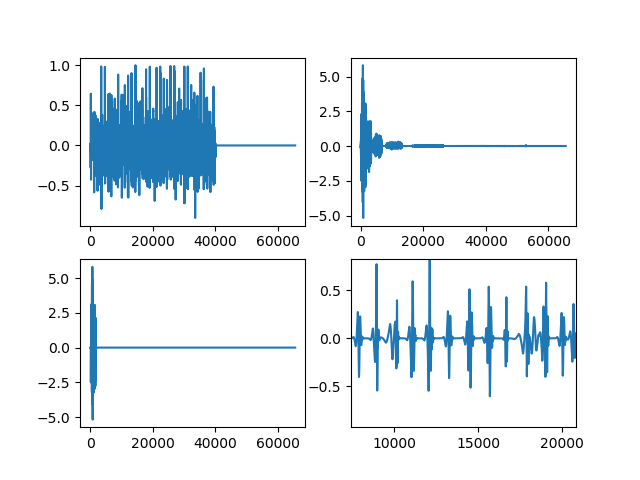

In [14]:
%matplotlib notebook
plt.subplot(2,2,1)
plt.plot(signal_in)
plt.subplot(2,2,2)
plt.plot(wav_decomp)
plt.subplot(2,2,3)
plt.plot(wav_thresh)
plt.subplot(2,2,4)
plt.plot(data_recomp)

plt.show()

<IPython.core.display.Javascript object>


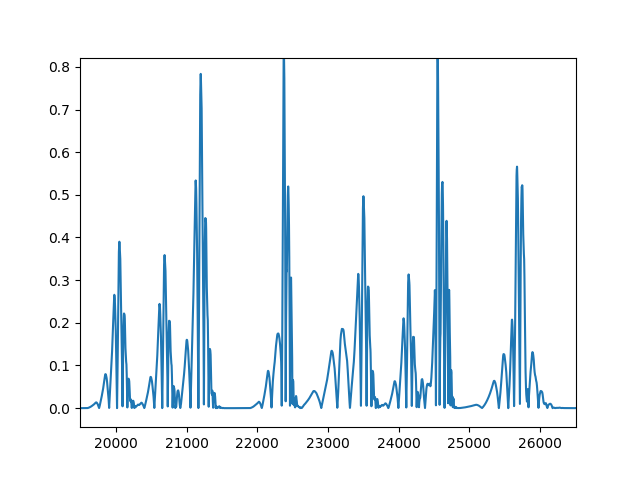

In [15]:
%matplotlib notebook
plt.plot(abs(data_recomp))
plt.show()

## Murmur elimination

<IPython.core.display.Javascript object>


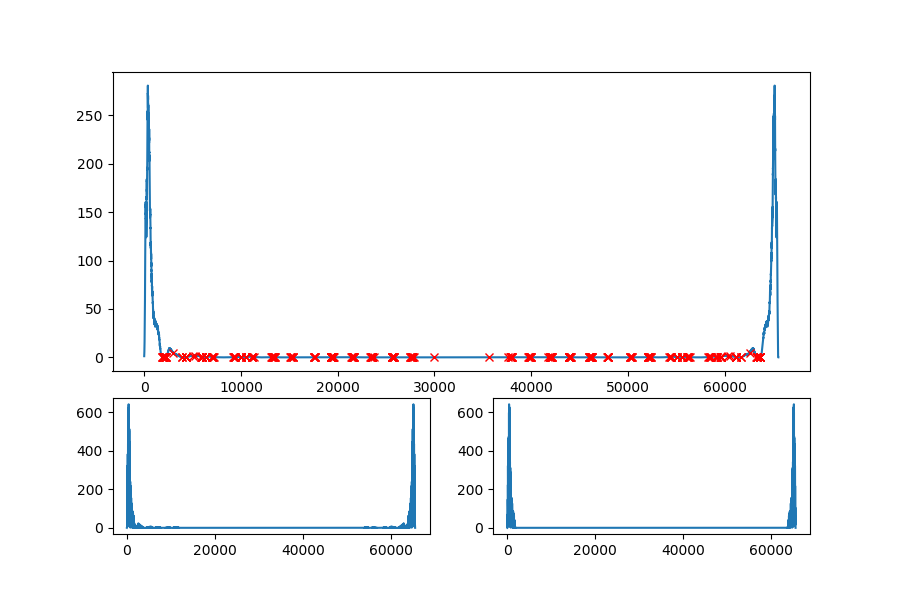

In [13]:
%matplotlib notebook
hs_nlp = murmur_elimination(data_recomp, samplerate=new_rate, Lf=30, simple_fcut=50,
                            endpoint_method='modified', plot=True)
wavio.write(f"{filename}_down_{new_rate}_murmur_eliminated.wav", hs_nlp, new_rate, sampwidth=3)

<IPython.core.display.Javascript object>


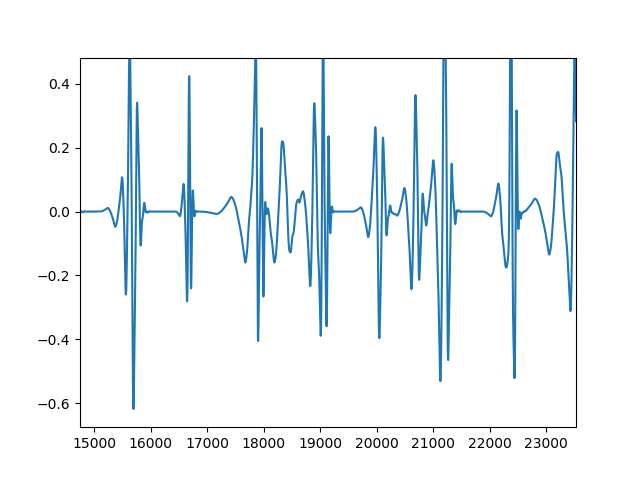

In [16]:
%matplotlib notebook
plt.plot(hs_nlp)
plt.show()

In [ ]:
%matplotlib notebook
gridsize = (2, 2)
fig = plt.figure(figsize=(9, 6))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (1, 0))
ax3 = plt.subplot2grid(gridsize, (0, 1), colspan=1, rowspan=2)

ax1.plot(data_recomp)
ax1.set_title('Data recomp')

ax2.plot(hs_nlp)
ax2.set_title('HS_NLP')

ax3.plot(data_recomp - hs_nlp)
ax3.set_title('Error')

plt.show()

# Boundary detection

<IPython.core.display.Javascript object>


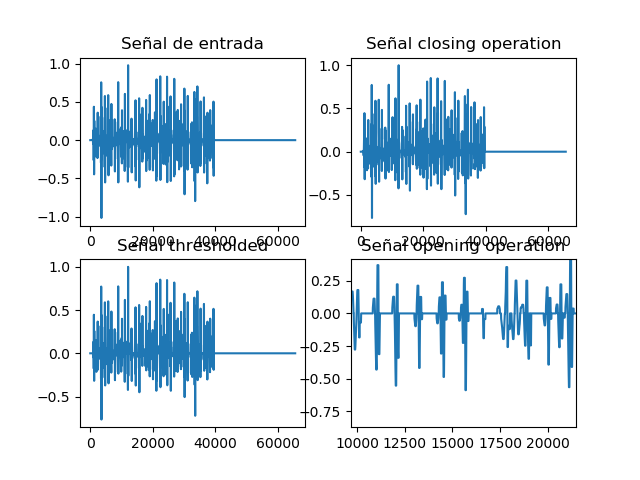

In [27]:
%matplotlib notebook
bd_signal = boundary_detection(hs_nlp, Q_clo=30, Q_op=50, plot=True)

<IPython.core.display.Javascript object>


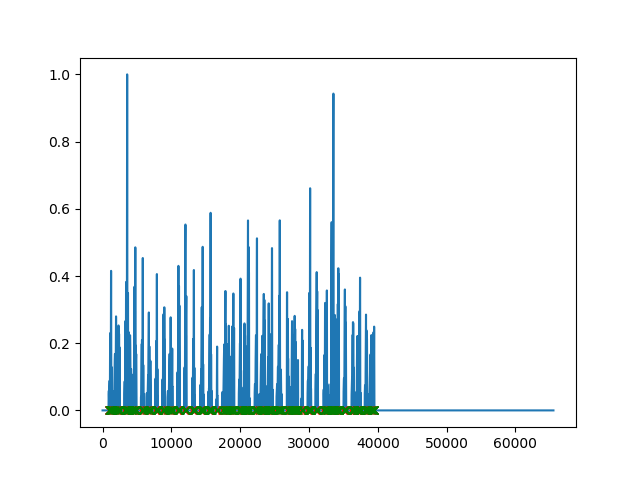

In [33]:
%matplotlib notebook
pot_onsets = find_potential_onset_offset(bd_signal, 'onset')
pot_offsets = find_potential_onset_offset(bd_signal, 'offset')
plt.plot(abs(bd_signal))
plt.plot(pot_onsets, [0] * len(pot_onsets), 'rx')
plt.plot(pot_offsets, [0] * len(pot_offsets), 'gx')
plt.show()

210
210


<IPython.core.display.Javascript object>


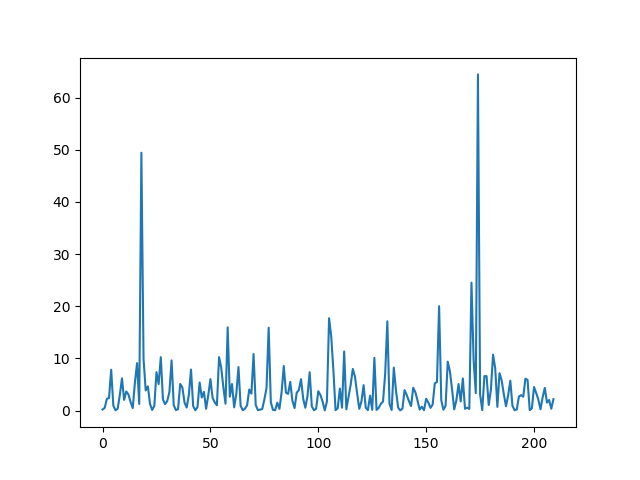

In [35]:
pot_onsets = find_potential_onset_offset(bd_signal, 'onset')
pot_offsets = find_potential_onset_offset(bd_signal, 'offset')

print(len(pot_onsets))
print(len(pot_offsets))

e_k = [sum(bd_signal[pot_onsets[k]:pot_offsets[k]+1] ** 2) 
       for k in range(len(pot_onsets))]

%matplotlib notebook
plt.plot(e_k)
plt.show()

64.47080225253603
16.117700563134008
[18, 58, 77, 105, 106, 132, 156, 171, 174]


<IPython.core.display.Javascript object>


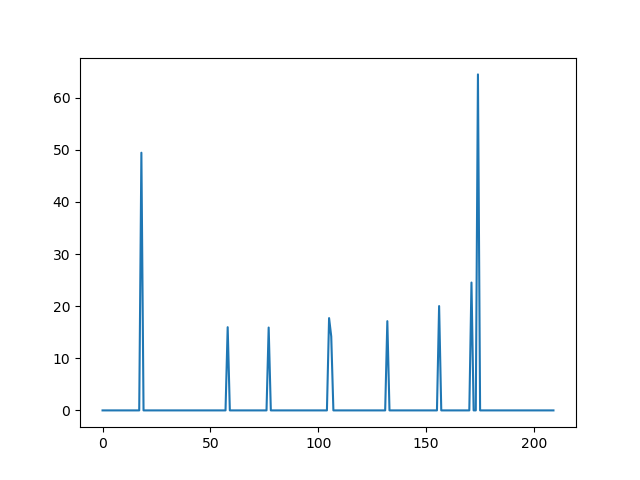

In [49]:
print(max(e_k))
print(max(e_k) * 0.25)

e_k_filtered = [e_k[k] if e_k[k] >= max(e_k) * 0.2 
                else 0 for k in range(len(pot_onsets))]
e_k_filt_indexes = [k for k in range(len(pot_onsets))
                    if e_k[k] >= max(e_k) * 0.2]
print(e_k_filt_indexes)

%matplotlib notebook
plt.plot(e_k_filtered)
plt.show()

<IPython.core.display.Javascript object>


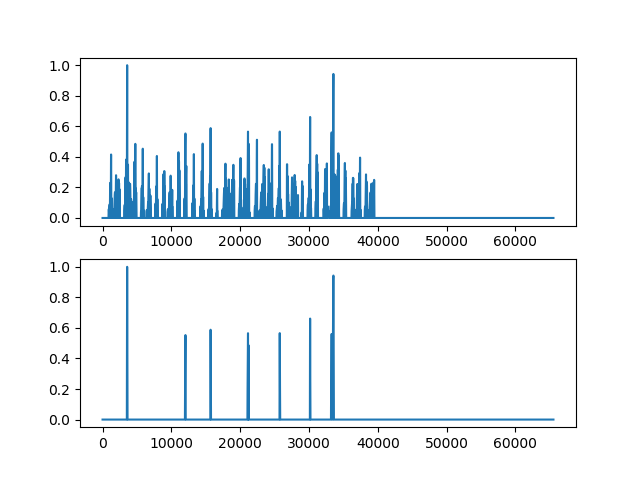

In [55]:
e_no_final = np.zeros(len(bd_signal))

for k in e_k_filt_indexes:
    e_no_final[pot_onsets[k]:pot_offsets[k]] += \
        bd_signal[pot_onsets[k]:pot_offsets[k]]

%matplotlib notebook
plt.subplot(2,1,1)
plt.plot(abs(bd_signal))
plt.subplot(2,1,2)
plt.plot(abs(e_no_final))
plt.show()